# **Sequence to Sequence Learning with Neural Networks (NIPS 2014**) 실습
 - 본 코드는 seq2seq의 구조를 이해하기 위해 연습용으로 적용한 코드이며 성능 향상이 아닌 구조 이해를 목적으로 진행하였습니다.

## 1.데이터 준비
- 사용할 토크나이저 :  spacy
- 사용할 데이터셋 : 파이토치 데이터셋인 Multi30k
- 독일어-영어의 번역을 진행하려고 합니다.

### 1.1 데이터 불러오기 및 토큰화
- Multi30k data를 불러오고 Field를 이용하여 단어 단위로 토큰화를 진행해줍니다.

In [ ]:
# 토큰화 모듈 설치
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 353 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 482 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
# torchtext 0.11.0부터 torchtext.regacy를 지원하지 않습니다.
# https://stackoverflow.com/questions/69240815/i-am-trying-to-importfrom-torchtext-legacy-data-import-field-bucketiterator-it
!pip install -U torchtext==0.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy
from torchtext.legacy.data import Field

#spacy의 영어, 독일어 토크나이저 가져오기
# spacy_en = spacy.load('en') 
# spacy_de = spacy.load('de') 
spacy_en = spacy.load('en_core_web_sm') 
spacy_de = spacy.load('de_core_news_sm') 

# 독일어(Deutsch) 문장을 토큰화한 뒤에 순서를 뒤집는 함수
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)][::-1]

# 영어(English) 문장을 토큰화하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]
    
# Field를 활용하여 토큰화 기준 설정
# 시작점을 <sos> 끝지점을 <eos> 소문자로 변경하여 진행
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
# torchtext의 Multi30k 임포트, 독일어 - 영어 번역문 데이터셋을 들고오며, 앞서 지정했던 field로 토큰화 진행
from torchtext.legacy.datasets import Multi30k

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC,TRG))

### 1.2 단어사전 만들기 & 배치로 묶기
- 기존의 언어마다 단어사전이 존재 하지만 사용하는 단어들로만 단어사전을 구성하여 차원의 크기를 줄여줌
- 비슷한 크기가 한 배치로하여 들어가야지 train이 효과적으로 잘 되며 padding의 수도 줄일 수 있다.

In [ ]:
# 단어사전 만들기
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [ ]:
print(len(SRC.vocab))
print(len(TRG.vocab))

7853
5893


In [ ]:
print(SRC.vocab.stoi)
print(TRG.vocab.stoi)

In [ ]:
# 비슷한 단어의 크기 만큼 묶어서 배치 만들어주기
import torch
from torchtext.legacy.data import BucketIterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=batch_size, device=device)

print(device)

cuda


- 지금까지는 INPUT데이터를 만드는 과정이었습니다.다음 그림과 같이 정리 되어있습니다.
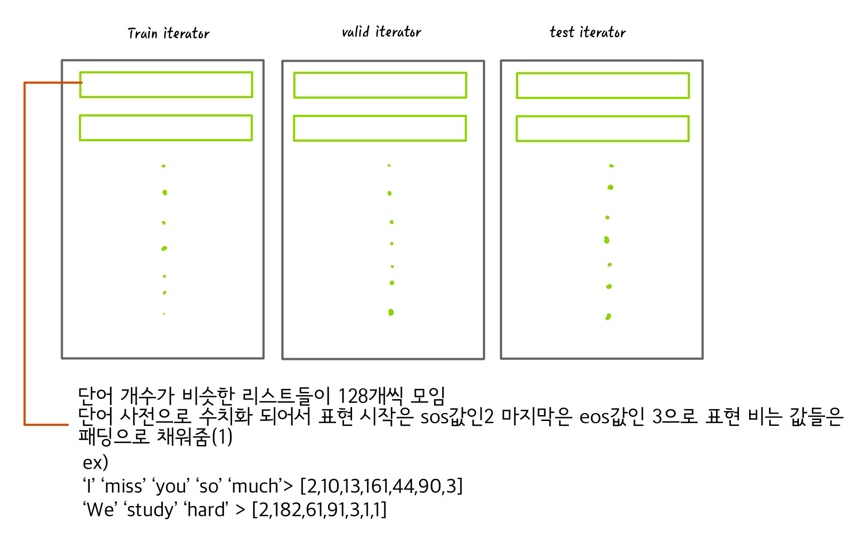

- 사실 이해하기 쉽게 I miss you so much 라는 문장이 하나의 리스트로 들어간 것처럼 그림에 표시하였지만 각 문장의 첫 번째 요소, 두 번째 요소들이 배열로하여 들어가 있습니다.
- 예를 들어 [i, we, you,...(배치 개수만큼)], [miss,love,study,...(배치 개수만큼)].. (단어의 개수만큼) 
- 즉 [(단어개수), (배치 크기)] 만큼의 데이터가 input으로 들어가게 됩니다.

## 2.Seq2Seq 구조 구현

### 2.1 인코더

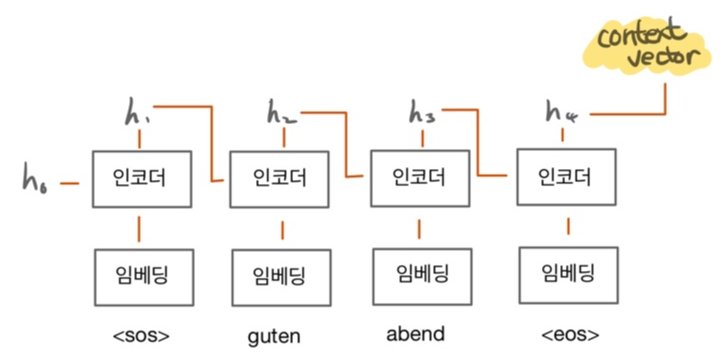

In [ ]:
import torch.nn as nn

# 인코더(Encoder) 아키텍처 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        # Embedding 레이어
        self.embedding = nn.Embedding(input_dim, embed_dim)

        # LSTM 레이어
        self.hid_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout_ratio)
        
        self.dropout = nn.Dropout(dropout_ratio)

    # 최종적으로 context vector를 반환(hidden, cell의 모습)
    # 임베딩을 거치고, rnn을 거쳐 결과값들이 반환된다.
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))

        outputs, (hidden, cell) = self.rnn(embedded)

        # 문맥 벡터(context vector) 반환
        return hidden, cell

### 2.2 디코더

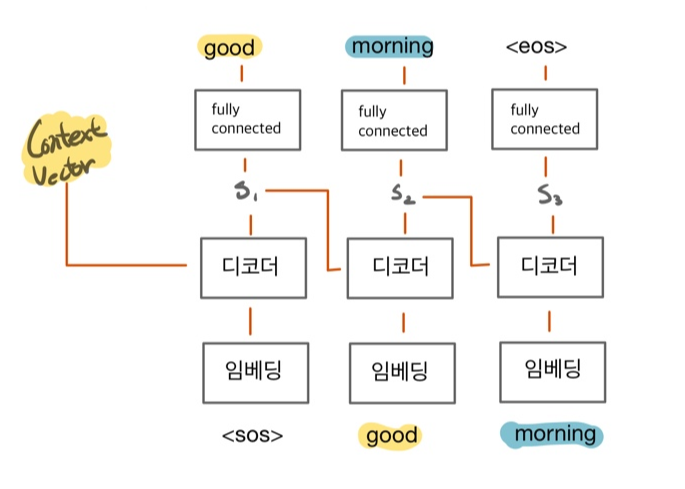

In [ ]:
# 디코더(Decoder) 아키텍처 정의
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        #Embedding 레이어
        self.embedding = nn.Embedding(output_dim, embed_dim)

        # LSTM 레이어
        self.hid_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout_ratio)
        
        # fully_connected 레이어
        self.output_dim = output_dim
        self.fc_ = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    # 각 과정마다 단어를 출력, 출력된 문장의 값들을 hidden과 cell로 출력   
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        result = self.fc_(output.squeeze(0))
        
        # result는 현재 출력 단어
        return result, hidden, cell

### 2.3 최종 seq2seq 구조

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    # 학습할 때는 완전한 형태의 소스 문장, 타겟 문장, teacher_forcing_ratio를 넣기
    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        hidden, cell = self.encoder(src)

        # 디코더(decoder)의 최종 결과를 담을 텐서 객체 만들기
        trg_len = trg.shape[0] # 단어 개수
        batch_size = trg.shape[1] # 배치 크기
        trg_vocab_size = self.decoder.output_dim # 출력 차원
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # 첫 번째 입력은 항상 <sos> 토큰
        input = trg[0, :]

        # 타겟 단어의 개수만큼 반복하여 디코더에 포워딩(forwarding)
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)

            outputs[t] = output # FC를 거쳐서 나온 현재의 출력 단어 정보
            top1 = output.argmax(1) # 가장 확률이 높은 단어의 인덱스 추출

            # teacher_forcing_ratio: 학습할 때 실제 목표 출력(ground-truth)을 사용하는 비율
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else top1 # 현재의 출력 결과를 다음 입력에서 넣기
        
        return outputs

## 3.학습 및 평가


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENCODER_EMBED_DIM = 256
DECODER_EMBED_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
ENC_DROPOUT_RATIO = 0.5
DEC_DROPOUT_RATIO = 0.5

In [ ]:
# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, ENCODER_EMBED_DIM, HIDDEN_DIM, N_LAYERS, ENC_DROPOUT_RATIO)
dec = Decoder(OUTPUT_DIM, DECODER_EMBED_DIM, HIDDEN_DIM, N_LAYERS, DEC_DROPOUT_RATIO)

# Seq2Seq 객체 선언
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
optimizer = optim.Adam(model.parameters())

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0
    
    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()

        output = model(src, trg)
        # output: [출력 단어 개수, 배치 크기, 출력 차원]
        output_dim = output.shape[-1]
        
        # 출력 단어의 인덱스 0은 사용하지 않음
        output = output[1:].view(-1, output_dim)
        # output = [(출력 단어의 개수 - 1) * batch size, output dim]
        trg = trg[1:].view(-1)
        # trg = [(타겟 단어의 개수 - 1) * batch size]
        
        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산
        
        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # 파라미터 업데이트
        optimizer.step()
        
        # 전체 손실 값 계산
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0
    
    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 평가할 때 teacher forcing는 사용하지 않음
            output = model(src, trg, 0)
            # output: [출력 단어 개수, 배치 크기, 출력 차원]
            output_dim = output.shape[-1]
            
            # 출력 단어의 인덱스 0은 사용하지 않음
            output = output[1:].view(-1, output_dim)
            # output = [(출력 단어의 개수 - 1) * batch size, output dim]
            trg = trg[1:].view(-1)
            # trg = [(타겟 단어의 개수 - 1) * batch size]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 20
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 35s
	Train Loss: 5.067 | Train PPL: 158.772
	Validation Loss: 5.063 | Validation PPL: 158.042
Epoch: 02 | Time: 0m 35s
	Train Loss: 4.518 | Train PPL: 91.688
	Validation Loss: 4.784 | Validation PPL: 119.626
Epoch: 03 | Time: 0m 35s
	Train Loss: 4.186 | Train PPL: 65.771
	Validation Loss: 4.497 | Validation PPL: 89.772
Epoch: 04 | Time: 0m 35s
	Train Loss: 3.960 | Train PPL: 52.437
	Validation Loss: 4.399 | Validation PPL: 81.383
Epoch: 05 | Time: 0m 35s
	Train Loss: 3.801 | Train PPL: 44.757
	Validation Loss: 4.303 | Validation PPL: 73.927
Epoch: 06 | Time: 0m 35s
	Train Loss: 3.636 | Train PPL: 37.941
	Validation Loss: 4.236 | Validation PPL: 69.100
Epoch: 07 | Time: 0m 35s
	Train Loss: 3.526 | Train PPL: 33.973
	Validation Loss: 4.046 | Validation PPL: 57.141
Epoch: 08 | Time: 0m 35s
	Train Loss: 3.386 | Train PPL: 29.545
	Validation Loss: 4.106 | Validation PPL: 60.730
Epoch: 09 | Time: 0m 35s
	Train Loss: 3.274 | Train PPL: 26.409
	Validation Loss: 3.973 | Val

In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # 인코더(endocer)에 소스 문장을 넣어 문맥 벡터(context vector) 계산
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        # 이전에 출력한 단어가 현재 단어로 입력될 수 있도록
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:] 

In [ ]:
src = tokenize_de("Guten Abend.")

print(f'소스 문장: {src}')
print("모델 출력 결과:", " ".join(translate_sentence(src, SRC, TRG, model, device)))

소스 문장: ['.', 'Abend', 'Guten']
전체 소스 토큰: ['<sos>', '.', 'abend', 'guten', '<eos>']
소스 문장 인덱스: [2, 4, 1163, 3798, 3]
모델 출력 결과: home . <eos>
